




<a name="_gjdgxs"></a><a name="_30j0zll"></a>**Deep Learning**

Course-End Project Problem Statement














<a name="_1fob9te"></a>**Course-End Project: Automating Port Operations**

**Project Statement:**

Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.

The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows.

- Buoy
- Cruise\_ship
- Ferry\_boat
- Freight\_boar
- Gondola
- Inflatable\_boat
- Kayak
- Paper\_boat
- Sailboat

Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.

As a deep learning engineer, your task is to:

1. Build a CNN network to classify the boat.
1. Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

**Dataset and Data Description:**

**boat\_type\_classification\_dataset.zip**

The dataset contains images of 9 types of boats. It contains a total of 1162 images. The training images are provided in the directory of the specific class itself.

Classes:

- ferry\_boat
- gondola
- sailboat
- cruise\_ship
- kayak
- inflatable\_boat
- paper\_boat
- buoy
- freight\_boat

**Perform the following steps:**

1. Build a CNN network to classify the boat.
   1. Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43.
   1. Use tf.keras.preprocessing.image\_dataset\_from\_directory to load the train and test datasets. This function also supports data normalization.

      *(Hint: image\_scale=1./255)*.

   1. Load train, validation and test dataset in batches of 32 using the function initialized in the above step.
   1. Build a CNN network using Keras with the following layers
      1. Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
      1. Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
      1. GLobalAveragePooling2D layer
      1. Dense layer with 128 neurons and activation relu
      1. Dense layer with 128 neurons and activation relu
      1. Dense layer with 9 neurons and activation softmax.
   1. Compile the model with Adam optimizer, categorical\_crossentropy loss, and with metrics accuracy, precision, and recall.
   1. Train the model for 20 epochs and plot training loss and accuracy against epochs.
   1. Evaluate the model on test images and print the test loss and accuracy.
   1. Plot heatmap of the confusion matrix and print classification report.
1. Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.
   1. Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1.
   1. Use tf.keras.preprocessing.image\_dataset\_from\_directory to load the train and test datasets. This function also supports data normalization.
      *(Hint: Image\_scale=1./255).*
   1. Load train, validation and test datasets in batches of 32 using the function initialized in the above step.
   1. Build a CNN network using Keras with the following layers.
      1. Load MobileNetV2 - Light Model as the first layer
         *(Hint: [Keras API Doc](https://keras.io/api/applications/mobilenet/))*
      1. GLobalAveragePooling2D layer
      1. Dropout(0.2)
      1. Dense layer with 256 neurons and activation relu
      1. BatchNormalization layer
      1. Dropout(0.1)
      1. Dense layer with 128 neurons and activation relu
      1. BatchNormalization layer
      1. Dropout(0.1)
      1. Dense layer with 9 neurons and activation softmax
   1. Compile the model with Adam optimizer, categorical\_crossentropy loss, and metrics accuracy, Precision, and Recall.
   1. Train the model for 50 epochs and Early stopping while monitoring validation loss.
   1. Evaluate the model on test images and print the test loss and accuracy.
   1. Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy.
1. Compare the results of both models built in steps 1 and 2 and state your observations.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from zipfile import ZipFile


zip_ref = ZipFile('/content/drive/MyDrive/DL/boats.zip','r')
zip_ref.extractall('/content/drive/MyDrive/DL')
zip_ref.close()




In [46]:
import os
test_dir = '/content/drive/MyDrive/DL/TEST_BOATS'
train_dir = '/content/drive/MyDrive/DL/TRAIN_BOATS'

class_names = os.listdir(train_dir)
height = 180
width = 180
batch_size = 32

In [47]:
import pathlib
data_dir = pathlib.Path(train_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1162


In [48]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=43,
  image_size=(height, width),
  batch_size=batch_size)

train_ds.class_names

Found 1162 files belonging to 9 classes.
Using 930 files for training.


['buoy',
 'cruise_ship',
 'ferry_boat',
 'freight_boat',
 'gondola',
 'inflatable_boat',
 'kayak',
 'paper_boat',
 'sailboat']

In [49]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 232 files for validation.


In [50]:
class_names = train_ds.class_names
print(class_names)

['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


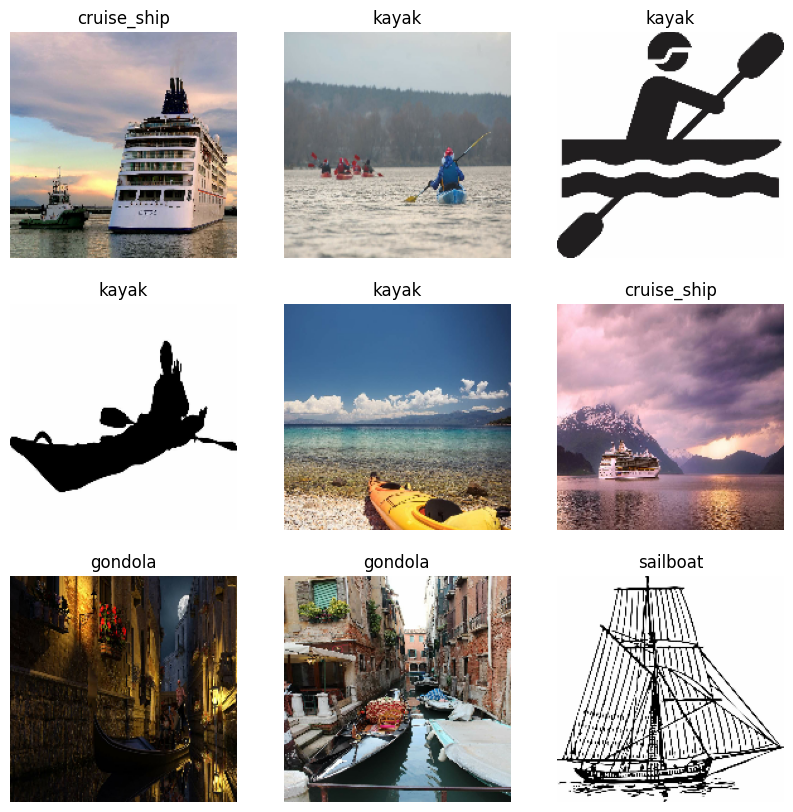

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [53]:
from tensorflow.keras import layers

num_classes = len(class_names)
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(height,
                                  width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# import library
from tensorflow.keras.models import Sequential

model = Sequential([

  layers.RandomFlip("horizontal",input_shape=(height,width,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255, input_shape=(height, width, 3)), #Scale the pixels
  layers.Conv2D(16, (3,3), padding='same', activation='relu'), # convolutiion with 16 fillters with a 3x3 kernal matrix
  layers.MaxPooling2D(), # Use max pooling

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2), # add a dropout layer to further reduce overfitting

  layers.Flatten(), # flatten the input for feeding to ANN
  layers.Dense(128, activation='relu'), # ANN hidde layer with 128 neurons
  layers.Dense(num_classes) # ANN output layer

])
# comple the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_4 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_4 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.01)
checkpoint=ModelCheckpoint('best_model.h5',monitor='val_loss',mode='min',verbose=1,save_best_only=True)


epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6237 - loss: 1.1367
Epoch 1: val_loss improved from inf to 1.47713, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6238 - loss: 1.1373 - val_accuracy: 0.5517 - val_loss: 1.4771
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6099 - loss: 1.1290
Epoch 2: val_loss improved from 1.47713 to 1.29513, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6097 - loss: 1.1295 - val_accuracy: 0.5733 - val_loss: 1.2951
Epoch 3/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6478 - loss: 1.0612
Epoch 3: val_loss improved from 1.29513 to 1.22870, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6467 - loss: 1.0635 - val_accuracy: 0.5733 - val_loss: 1.2287
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6363 - loss: 1.0321
Epoch 4: val_loss did not improve from 1.22870
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6363 - loss: 1.0327 - val_accuracy: 0.5603 - val_loss: 1.4192
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6812 - loss: 0.9332
Epoch 5: val_loss improved from 1.22870 to 1.13824, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6802 - loss: 0.9356 - val_accuracy: 0.6466 - val_loss: 1.1382
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6718 - loss: 0.9784
Epoch 6: val_loss did not improve from 1.13824
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6709 - loss: 0.9806 - val_accuracy: 0.6034 - val_loss: 1.3681
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6647 - loss: 0.9910
Epoch 7: val_loss did not improve from 1.13824
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6650 - loss: 0.9895 - val_accuracy: 0.6293 - val_loss: 1.2321
Epoch 8/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6712 - loss: 0.9441
Epoch 8: val_loss did not improve from 1.13824
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6718 - loss: 0.9423 - val_accuracy: 0.6034 - val_loss: 1.2973
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6618 - loss: 0.8933
Epoch 9: val_loss did not improve from 1.13824
30/30 ━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7079 - loss: 0.8105 - val_accuracy: 0.6810 - val_loss: 1.1356
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6888 - loss: 0.9062
Epoch 11: val_loss did not improve from 1.13562
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6887 - loss: 0.9064 - val_accuracy: 0.6509 - val_loss: 1.1842
Epoch 12/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7310 - loss: 0.7960
Epoch 12: val_loss did not improve from 1.13562
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7304 - loss: 0.7979 - val_accuracy: 0.6422 - val_loss: 1.2055
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7549 - loss: 0.7240
Epoch 13: val_loss improved from 1.13562 to 1.06231, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7538 - loss: 0.7269 - val_accuracy: 0.6897 - val_loss: 1.0623
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7829 - loss: 0.6754
Epoch 14: val_loss did not improve from 1.06231
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7819 - loss: 0.6776 - val_accuracy: 0.6681 - val_loss: 1.3004
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7620 - loss: 0.6882
Epoch 15: val_loss did not improve from 1.06231
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7617 - loss: 0.6885 - val_accuracy: 0.6336 - val_loss: 1.4317
Epoch 16/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7389 - loss: 0.7270
Epoch 16: val_loss did not improve from 1.06231
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7393 - loss: 0.7264 - val_accuracy: 0.6638 - val_loss: 1.2882
Epoch 17/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7884 - loss: 0.6007
Epoch 17: val_loss improved from 1.06231 to 1.04

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7876 - loss: 0.6023 - val_accuracy: 0.7112 - val_loss: 1.0453
Epoch 18/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7913 - loss: 0.5793
Epoch 18: val_loss did not improve from 1.04532
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7907 - loss: 0.5816 - val_accuracy: 0.6164 - val_loss: 1.4530
Epoch 19/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7967 - loss: 0.6040
Epoch 19: val_loss improved from 1.04532 to 1.01943, saving model to best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7963 - loss: 0.6042 - val_accuracy: 0.7284 - val_loss: 1.0194
Epoch 20/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8230 - loss: 0.5457
Epoch 20: val_loss did not improve from 1.01943
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8219 - loss: 0.5472 - val_accuracy: 0.6595 - val_loss: 1.2659
Epoch 21/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7802 - loss: 0.5961
Epoch 21: val_loss did not improve from 1.01943
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7804 - loss: 0.5965 - val_accuracy: 0.7026 - val_loss: 1.0976
Epoch 22/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8005 - loss: 0.5721
Epoch 22: val_loss did not improve from 1.01943
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8004 - loss: 0.5717 - val_accuracy: 0.7112 - val_loss: 1.0885
Epoch 23/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8522 - loss: 0.4584
Epoch 23: val_loss improved from 1.01943 to 0.90

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8517 - loss: 0.4600 - val_accuracy: 0.7629 - val_loss: 0.9065
Epoch 24/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8543 - loss: 0.4149
Epoch 24: val_loss did not improve from 0.90646
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8539 - loss: 0.4175 - val_accuracy: 0.7414 - val_loss: 1.0706
Epoch 25/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8363 - loss: 0.4566
Epoch 25: val_loss did not improve from 0.90646
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8360 - loss: 0.4577 - val_accuracy: 0.7112 - val_loss: 1.1507
Epoch 26/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8490 - loss: 0.4611
Epoch 26: val_loss did not improve from 0.90646
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8485 - loss: 0.4612 - val_accuracy: 0.7284 - val_loss: 1.1943
Epoch 27/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8338 - loss: 0.4446
Epoch 27: val_loss did not improve from 0.90646


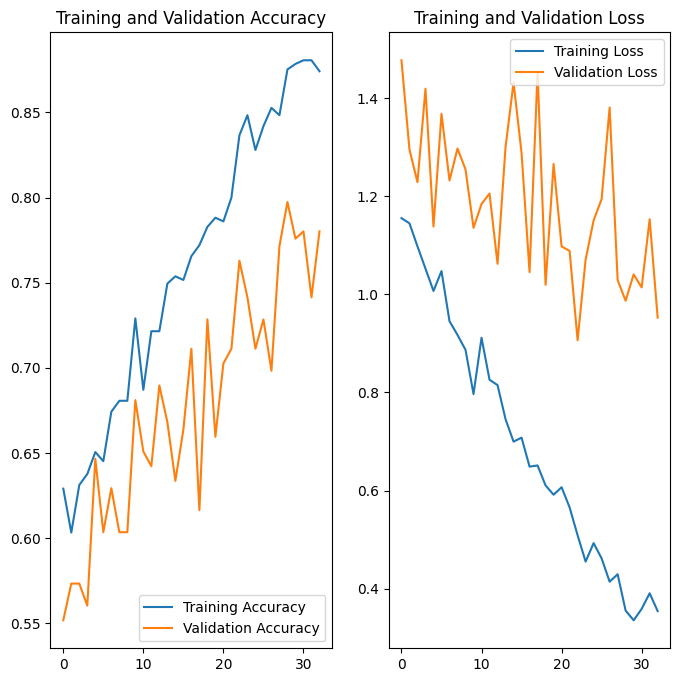

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(33)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

import numpy as np
import pprint

images = os.listdir(test_dir+'/all')

display_images = {}
output = {}
for i,image in enumerate(images):
  path = test_dir+'/all/'+image
  img = tf.keras.utils.load_img(
      path, target_size=(height, width)
  )


  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array,verbose=False)
  score = tf.nn.softmax(predictions[0])
  output[image] = class_names[np.argmax(score)], 100 * np.max(score)

  # if i % 25 == 0 and i != 0:
  #   plt.imshow(img)

  #   plt.show()
  #   plt.title(
  #       " {} , confidence : {:.2f} percent"
  #       .format(class_names[np.argmax(score)], 100 * np.max(score)))
pprint.pprint(output)

{'1.jpg': ('ferry_boat', 99.98490810394287),
 '10.jpg': ('sailboat', 96.82704210281372),
 '100.jpg': ('gondola', 97.6302981376648),
 '101.jpg': ('cruise_ship', 99.80917572975159),
 '102.jpg': ('sailboat', 99.37194585800171),
 '103.jpg': ('sailboat', 34.59676206111908),
 '104.jpg': ('sailboat', 89.2833948135376),
 '105.jpg': ('inflatable_boat', 61.80481314659119),
 '106.jpg': ('gondola', 97.67650961875916),
 '107.jpg': ('cruise_ship', 99.98873472213745),
 '108.jpg': ('gondola', 88.67397904396057),
 '109.jpg': ('cruise_ship', 52.98231244087219),
 '11.jpg': ('cruise_ship', 95.92013359069824),
 '110.jpg': ('kayak', 91.99803471565247),
 '111.jpg': ('sailboat', 74.0770161151886),
 '112.jpg': ('gondola', 87.66610026359558),
 '113.jpg': ('ferry_boat', 97.6936399936676),
 '114.jpg': ('cruise_ship', 72.24851250648499),
 '115.jpg': ('sailboat', 71.47204875946045),
 '116.jpg': ('sailboat', 99.70104694366455),
 '117.jpg': ('cruise_ship', 92.33211278915405),
 '118.jpg': ('sailboat', 89.6750152111053